In [1]:
# Imports
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
sys.path.insert(1, r'C:\Users\soube\OneDrive\Desktop\Hammudi\Bachelorarbeit\Repository\AP-rent-determination\tree_models\tree_model_functions.py')
import tree_model_functions

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# Reduce memory usage of dataframe
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Import dataframe from csv
def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [3]:
# Selecting the DataSource
dataSource = r"C:\Users\soube\OneDrive\Desktop\Hammudi\Bachelorarbeit\Repository\AP-rent-determination\students_data\cleaned_data_with_IQR_removal.csv"

# Selecting columns to drop out of featureList and creating LabelList
featureDropList = ["_id", "observationDate", "state", "city", "AP_community", "community_id", "base_rent", "qm2_rent", "DE_qm2_rent"]
LabelList = ["qm2_rent"]

# Create DataFrame from DataSource
try: 
    dataframe = import_data(dataSource)
except:
    dataframe = pd.read_csv(dataSource)

# Create list of unique states
states = dataframe["state"].unique()

for category in ["postcode"]:
    dataframe[category] = dataframe[category].astype("category")
    dataframe[category] = dataframe[category].cat.codes

#dataframe.drop(dataframe.filter(regex = "second"), axis = 1, inplace = True)
#dataframe.drop(dataframe.filter(regex = "third"), axis = 1, inplace = True)

Memory usage of dataframe is 122.97 MB
Memory usage after optimization is: 44.49 MB
Decreased by 63.8%


In [4]:
# Loop throug all states to train them seperately

# Create list for model scores
state_prediction_score = []
for state in states:
    df = dataframe
    df = df[df["state"]  == state]

    # Create feature and label lists
    y = df[LabelList]
    X = df.drop(featureDropList, axis = 1)
    feature_list = list(X.columns)

    y = np.array(y)
    X = np.array(X)

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

    # Instantiate model
    hgbr = HistGradientBoostingRegressor(random_state = 0)

    # Train the model on training data
    hgbr.fit(X_train, y_train)

    # Use the Regressors's predict method on the test data
    predictions = hgbr.predict(X_test)

    # Calculate relative prediction errors
    errors = [100 * (abs(predictions[i] - y_test[i])/ y_test[i]) for i in range(min(len(predictions), len(y_test)))]

    # Count of predictions that are at least 10% accurate
    count_good_predictions = sum(1 for i in errors if i <= 10)

    # Proportion of good predictions for the Testset
    good_predictions = round(np.mean(100 * (count_good_predictions / len(errors))), 2)
    
    state_prediction_score.append([state, good_predictions])

c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConve

In [5]:
print(state_prediction_score)

[['Schleswig-Holstein', 70.52], ['Bremen', 66.36], ['Hessen', 61.81], ['Hamburg', 60.89], ['Thüringen', 72.69], ['Nordrhein-Westfalen', 55.62], ['Mecklenburg-Vorpommern', 69.67], ['Bayern', 54.56], ['Sachsen', 69.0], ['Baden-Württemberg', 54.75], ['Brandenburg', 73.17], ['Saarland', 63.41], ['Berlin', 74.02], ['Sachsen-Anhalt', 73.47], ['Rheinland-Pfalz', 63.6], ['Niedersachsen', 63.61]]


In [6]:
# Convert state_prediction_score list into DataFrame
state_prediction_df = pd.DataFrame(state_prediction_score, columns = ["state", "score"])
# Calculate the average score of the model
prediction_score = state_prediction_df["score"].mean()
print("Model score :", prediction_score, "%")

Model score : 65.446875 %


In [7]:
# mean_feature_importances from randomForest
new_mean_importances_list = [['livingSpace', 0.10918749999999999],['constructionYear', 0.0825],['nearest_airport', 0.0349375],['third_shelter', 0.029187499999999998],['second_university', 0.029125],['third_children', 0.0278125],['third_university', 0.0241875],['roomCount', 0.024],['furnished', 0.021249999999999998],['second_airport', 0.0194375],['floorHeating', 0.0178125],['Apartment', 0.01775],['latitude', 0.016624999999999997],['postcode', 0.01575],['second_children', 0.01575],['third_beergarden', 0.014937500000000001],['second_shelter', 0.0148125],['third_hospital', 0.0138125],['nearest_shelter', 0.012875],['third_clinic', 0.0125],['third_harbour', 0.0119375],['energyConsumption', 0.0116875],['nearest_harbour', 0.0109375],['third_nightclub', 0.010875000000000001],['second_clinic', 0.010750000000000001],['second_beergarden', 0.0095625],['ERSTBEZUG', 0.0093125],['builtInKitchen', 0.008875],['second_harbour', 0.0086875],['energyType', 0.0085625],['second_tram_station', 0.0084375],['third_tram_station', 0.007625],['second_hospital', 0.0075625],['second_nightclub', 0.0074375],['nearest_university', 0.007375],['lift', 0.007062499999999999],['longitude', 0.0068125],['nearest_tram_station', 0.006687500000000001],['third_airport', 0.0061875],['nearest_children', 0.0056875],['third_bar', 0.005375],['third_charging_station', 0.0053125],['nearest_beergarden', 0.0049375],['third_train_station', 0.0048125],['floor', 0.004625],['nearest_hospital', 0.004625],['second_bar', 0.0045625],['third_recycling_center', 0.0045],['parking', 0.004375],['second_hotel', 0.0043125],['second_charging_station', 0.00425],['second_recycling_center', 0.00425],['third_seniors', 0.0040625],['Zentralheizung', 0.0040625],['nearest_hotel', 0.004],['nearest_clinic', 0.0039375],['energyEfficiencyClass', 0.003875],['nearest_recycling_center', 0.003875],['second_train_station', 0.003875],['nearest_nightclub', 0.003875],['third_hotel', 0.003875],['nearest_supermarket', 0.0038125],['nearest_fuel', 0.00375],['nearest_museum', 0.00375],['third_museum', 0.00375],['second_motorway_junction', 0.003625],['second_seniors', 0.003625],['second_kindergarden', 0.0035625],['nearest_motorway_junction', 0.0035625],['third_bus_stop', 0.0035],['third_motorway_junction', 0.0035],['nearest_bar', 0.0034375],['second_restaurant', 0.003375],['second_museum', 0.003375],['nearest_bus_stop', 0.0033125],['nearest_charging_station', 0.0033125],['nearest_kindergarden', 0.0032500000000000003],['nearest_restaurant', 0.0032500000000000003],['nearest_school', 0.0031875000000000002],['third_school', 0.0031875000000000002],['nearest_DIY_store', 0.0031875000000000002],['second_DIY_store', 0.0031875000000000002],['third_DIY_store', 0.0031875000000000002],['second_fuel', 0.0031875000000000002],['third_kindergarden', 0.003125],['nearest_train_station', 0.003125],['third_fuel', 0.0030625],['nearest_pharmacy', 0.003],['nearest_ATM', 0.0029375],['nearest_seniors', 0.0029375],['second_bus_stop', 0.002875],['second_school', 0.0028125],['nearest_bakery', 0.00275],['second_supermarket', 0.00275],['nearest_doctor', 0.00275],['second_doctor', 0.0026875000000000002],['second_hairdresser', 0.002625],['third_restaurant', 0.002625],['third_supermarket', 0.0025625],['third_doctor', 0.0025625],['nearest_hairdresser', 0.0025],['third_hairdresser', 0.0025],['third_pharmacy', 0.0025],['third_ATM', 0.0024375],['third_bakery', 0.0024375],['second_ATM', 0.002375],['second_pharmacy', 0.002375],['second_bakery', 0.0022500000000000003],['Etagenwohnung', 0.0021875],['Wohnung', 0.0021875],['cellar', 0.002125],['Neubau', 0.0021249999999999997],['balcony', 0.0020625],['coord_confidence', 0.002],['NEUWERTIG', 0.002],['garden', 0.001875],['barrierfree', 0.0018125],['TEIL_VOLLSANIERT', 0.00175],['Sonstiges', 0.00175],['wheelchair', 0.0016250000000000001],['TEIL_VOLLRENOVIERT', 0.0015625],['Erdgeschosswohnung', 0.0014375],['terrace', 0.001375],['Etagenheizung', 0.0011875],['cableConnection', 0.0011250000000000001],['outsideParking', 0.0011250000000000001],['Dachgeschosswohnung', 0.0010625],['Fliesen', 0.0010625],['Teppich', 0.0009375],['Parkett', 0.000875],['Laminat', 0.000625],['Altbau', 0.0005625000000000001],['PVC/Linoleum', 0.0005625000000000001],['Maisonette', 0.0005],['undergroundParking', 0.000375],['Penthouse', 0.0003125]]
sum(x[1] for x in new_mean_importances_list)

0.9993124999999999

Text(0.5, 1.0, 'Cumulative Importances')

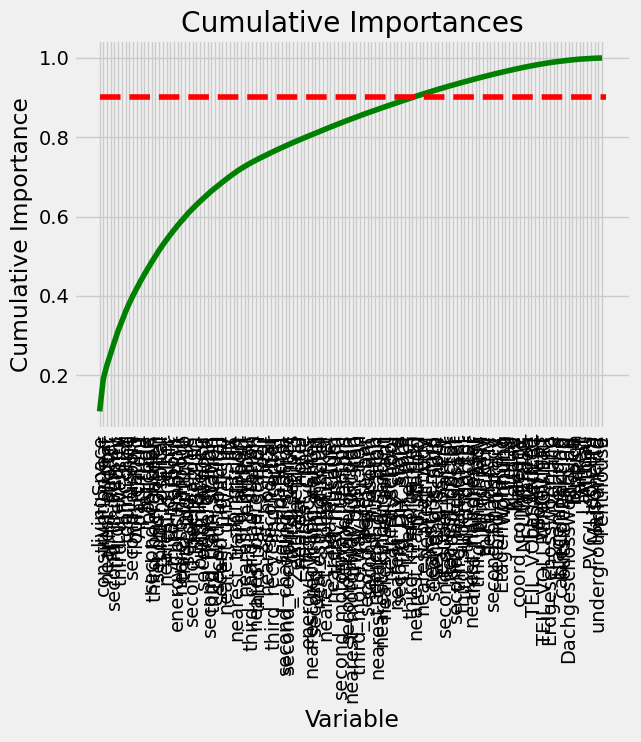

In [11]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in new_mean_importances_list]
sorted_features = [importance[0] for importance in new_mean_importances_list]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# list of x locations for plotting
x_values = list(range(len(new_mean_importances_list)))

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 90% of importance retained
plt.hlines(y = 0.90, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')

In [12]:
# Find number of features for cumulative importance of 90%
# Add 1 because Python is zero-indexed
num_of_important_features = np.where(cumulative_importances > 0.999)[0][0] + 1
print('Number of features for 90% importance:', num_of_important_features)

Number of features for 90% importance: 136


In [13]:
#List with most important features
new_mean_importances_list = new_mean_importances_list[:num_of_important_features]

#List with most important features without importances
new_mean_importances_list_names = [item[0] for item in new_mean_importances_list]

In [20]:
# Loop throug all states to train them seperately

# Create list for model scores
state_prediction_score_imp = []

for state in states:
    df = dataframe
    df = df[df["state"]  == state]

    # Create feature and label lists
    y = df[LabelList]
    X = df[new_mean_importances_list_names]

    y = np.array(y)
    X = np.array(X)

    # Train test split
    important_X_train, important_X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

    # Instantiate model
    hgbr = HistGradientBoostingRegressor(random_state=0)

    # Train the model on training data
    hgbr.fit(important_X_train, y_train)

    # Use the Regressors's predict method on the test data
    predictions = hgbr.predict(important_X_test)
    
    # Calculate relative prediction errors
    errors = [100 * (abs(predictions[i] - y_test[i])/ y_test[i]) for i in range(min(len(predictions), len(y_test)))]

    # Count of predictions that are at least 10% accurate
    count_good_predictions = sum(1 for i in errors if i <= 10)

    # Proportion of good predictions for the Testset
    good_predictions = round(np.mean(100 * (count_good_predictions / len(errors))), 2)

    state_prediction_score_imp.append([state, good_predictions])

c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConve

In [26]:
print(state_prediction_score_imp)

[['Schleswig-Holstein', 71.32], ['Bremen', 66.36], ['Hessen', 61.89], ['Hamburg', 60.74], ['Thüringen', 72.69], ['Nordrhein-Westfalen', 55.4], ['Mecklenburg-Vorpommern', 69.3], ['Bayern', 53.72], ['Sachsen', 69.4], ['Baden-Württemberg', 54.56], ['Brandenburg', 73.85], ['Saarland', 63.41], ['Berlin', 74.02], ['Sachsen-Anhalt', 73.47], ['Rheinland-Pfalz', 64.5], ['Niedersachsen', 64.08]]


In [27]:
# Convert state_prediction_score list into DataFrame
state_prediction_df = pd.DataFrame(state_prediction_score_imp, columns = ["state", "score"])
# Calculate the average score of the model
prediction_score_imp = state_prediction_df["score"].mean()
print("Model score :", prediction_score_imp, "%")

Model score : 65.544375 %


In [17]:
with open(r'C:\Users\soube\OneDrive\Desktop\Hammudi\Bachelorarbeit\Repository\AP-rent-determination\tree_models_notes\hgbr_scores.txt', 'w') as f:
    f.write("Hyperparameters:")
    f.write('\n')
    params = repr(hgbr.get_params())
    f.write(params)
    f.write('\n')
    f.write('\n')
    f.write("Model score with all features:")
    f.write('\n')
    state_prediction_score = repr(state_prediction_score)
    f.write(state_prediction_score)
    f.write('\n')
    prediction_score = repr(prediction_score)
    f.write(prediction_score)
    f.write('\n')
    f.write('\n')
    f.write("Model score with important features:")
    f.write('\n')
    state_prediction_score = repr(state_prediction_score_imp)
    f.write(state_prediction_score)
    f.write('\n')
    prediction_score = repr(prediction_score_imp)
    f.write(prediction_score)